# Testing out numerical solver code

## current setup
implicit - explicit solver with an implicit multigrid solver for the diffusion term and RK45 for the reaction term.

## Objectives 

## Model considerations 
* Species
    1. Cell density (sender and pulse cells)
    1. Nutrient density 
    1. mScarlet
* Reactions 
    1. cell growth and diffusion 
        * Cells diffuse very slowly
        * nutrient-dependent growth (from Liu et al 2011, Science) 
        $$  $$ 
    1. Constitutive fluorescence
        * Basal protein expression 
        * initial protein concentration set to fixed point of max nutrient
    1. Dilution and degradation 
        * Assume that all proteins are degradation tagged
    1. Diffusion 
        * Here, you're going to use convoultion of the diffusion kernel
        * Diffusion in/out of cell is considered faster than spatial diffusion at these scales
    1. Parameters
        * We are also assuming, for the moment, that each time point is 6 minutes. Parameters with time dimensions shown below may use different units than the parameter from the cited paper.
        * dx: Length modification of diffusion terms. In the compartmental model, diffusion is calculated via Ficks' first law, where the flux between two adjacent compartments is equal to the flux multiplied by the area of the interface between the components :  
        $\frac{\mathrm{d} C}{\mathrm{d} t} $ 
        in continuous form gives up 
        $\Delta C = D \frac{A}{V} \frac{\Delta C}{\Delta x} = D \frac{2.25 \cdot 5 \cdot \mathrm{scale}^2 \mathrm{mm}^2}{\mathrm{scale} \cdot 2.25^2 \cdot 5 \mathrm{mm}^3} \frac{\Delta C \cdot \mathrm{scale}}{2.25 \mathrm{mm}} = \frac{D \Delta C \mathrm{scale}^2}{2.25^2 \mathrm{mm}^2}$. the dx parameter below is the symbol $A$ in this equation.
        * Dc : Diffusion rate for cells. $7\frac{mm^2}{min}$
        * rc : Division rate of cells. $\frac{1.14}{min}$
        * Kn : Half-point of nutrient availability. 75
        * Dn : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * kn : Consumption rate of nutrient by cells
        * Da : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * xs : Expression rate of protein. 


### Model equations
Species:
* $c_p$ : Propagator cells
* $c_s$ : Sender cells
* $n$ : Nutrient
* $a$ : AHL (cell-cell signaling molecule)
* $s$ : Synthase (protein that creates AHL)
* $r$ : Transcriptional repressor (halts production of synthase)

Parameters
* $h_i$ : Hill coefficient
* $k_i$ : Hill function IC50 concentration
* $r_i$ : Species production rate
* $p_i$ : Species degradation or consumption rate
* $D_i$ : Species diffusion coefficient

Inducer-dependent protein production approximation:

$ H(a, n, k) = \frac{a^n}{k^n + a^n}$

$ H_n(a, n, k) = 1 - H(a,n,k) $

Differential equations

$ \partial_t c_p = D_c \Delta c_p + r_c H(n,h_n,90)\,c_p $

$ \partial_t c_s = D_c \Delta c_p + r_c H(n,h_n,90)\,c_s $

$ \partial_t n = D_n \Delta n - p_n H(n,h_n,90)\,(c_p + c_s) $

$ \partial_t a = D_a \Delta a + r_a\,s\,(c_p+c_s)-p_a\,a $

Where $c_s>0$

$ \partial_t s = D_c \Delta s  + (r_s\,c_s - r_c\,s)\,H(n,h_n,90) - p_s\,s$

Where $c_p>0$

$ \partial_t s = D_c \Delta s  + (r_s\,c_p\, H(a,h_s,k_s) H_n(r,h_C,k_C) - r_c\,s)\,H(n,h_n,90) - p_s\,s$

Where both $c_p=0$ and $c_s=0$

$ \partial_t s = D_c \Delta s - p_p\,s$

Where $c_p>0$

$ \partial_t r = D_c \Delta r  + (r_r\,c_p\, H(a,h_r,k_r) - r_c\,r)\,H(n,h_n,90) - p_r\,r$

Where both $c_p=0$ 

$ \partial_t r = D_c \Delta r - p_r\,r$


Inducer-dependent protein production approximation:

$ H(a, n, k) = \frac{a^n}{k^n + a^n}$

Differential equations

$ \partial_t c = D_c \Delta c + r_c H(n,h_n,90)\,c $

$ \partial_t n = D_n \Delta n - k_n H(n,h_n,90)\,c $


In [1]:
# imports
from __future__ import division, print_function

import itertools as itt
import time

import numpy as np
import pandas as pd
import os
import sys
import string
import selenium
import scipy.integrate as itg
import scipy.optimize as opt
import scipy.interpolate as itp
import scipy.ndimage as ndi
import scipy.sparse as sparse

import matplotlib as mpl
mpl.use("Agg")

import itertools

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # Add the path of ffmpeg here!!

import matplotlib.animation as anm
import skimage.measure
import skimage.filters
import numba
import gc

from multiprocessing import Pool, Process

%load_ext memory_profiler
%load_ext line_profiler
import timeit

from IPython.display import HTML

%matplotlib inline

## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

I use a convolution function to calculate the diffusion terms. 

In [69]:
cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(6)
def write_movie(im_arr, t_vec, skip=1, n_frames=200):
    
    frames, s, h, w = im_arr.shape
    t_points = np.arange(0,t_vec.max(),n_frames)
    f_points = np.arange(frames)
    
    #frames = len(t)
    
    t, s, h, w = im_arr.shape
    xticks = []
    xticklabels = []
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(2,3, figsize=(10,7))
    axs = axs.flatten()
    im_list = [0,0,0,0,0,0]
    
    # Plot cell densities
    ax_ind = 0
    ax = axs[ax_ind]
    indxs = [cp_i, cs_i]
    vmax = im_arr[-1,indxs,:,:].sum(axis=0).max()
    vmin = im_arr[-1,indxs,:,:].sum(axis=0).min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[ax_ind] = im
    
    # Plot nutrient densities
    ax_ind = 1
    ax = axs[ax_ind]
    indxs = [n_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[ax_ind] = im
    
    # Plot pulser synthase densities
    ax_ind = 2
    ax = axs[ax_ind]
    indxs = [s_i, cp_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    indxs = [s_i, cs_i]
    v_arr += im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('synthases')
    im_list[ax_ind] = im
    
    # Plot ahl conc
    ax_ind = 3
    ax = axs[ax_ind]
    indxs = [a_i]
    v_arr = im_arr[:,indxs,:,:]
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('ahl')
    im_list[ax_ind] = im
    
    # Plot pulser repressor densities
    ax_ind = 4
    ax = axs[ax_ind]
    indxs = [r_i, cp_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('repr')
    im_list[ax_ind] = im
    
    # Plot total cellular protein
    ax_ind = 5
    ax = axs[ax_ind]
    indxs = [s_i, r_i]
    v_arr = im_arr[:,indxs,:,:].sum(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cellular protein')
    im_list[5] = im

    # animation function.  This is called sequentially
    t_points = np.linspace(0,t_vec.max(), 200)
    f_inds = []
    t_ind = 0
    for tp in t_points:
        while tp > t_vec[t_ind]:
            t_ind += 1
        f_inds.append(t_ind-1)
        
    def animate(t_point):
        i = f_inds[t_point]
        
        # Plot cell densities
        ax = axs[0]
        indxs = [cp_i, cs_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[1]
        indxs = [n_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[1].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[2]
        indxs = [s_i, cp_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        indxs = [s_i, cs_i]
        frame_arr += im_arr[i,indxs,:,:].prod(axis=0)
        im_list[2].set_array(frame_arr)
        
        # Plot ahl
        ax = axs[3]
        indxs = [a_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[3].set_array(frame_arr)

        # Plot repr
        ax = axs[4]
        indxs = [cp_i, r_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        im_list[4].set_array(frame_arr)

        # Plot cellular protein
        ax = axs[5]
        indxs = [s_i, r_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[5].set_array(frame_arr)

        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=n_frames)

#     anim.save('./animation_test.gif', writer='pillow')
#     fig.tight_layout()
    plt.close('all')
    return anim
#     HTML(anim.to_html5_video())


def prep_initial_condition(cs_spots, cp_spots, ahl_spots, dims, p0, A):
    rp,    Kn,  Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od = p0
    species, n_h, n_w = dims
    
    cs_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cs_spots:
        cs_cells += disk(cs_cells, np.array(center), scale_s)*od
        
    cp_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cp_spots:
        cp_cells += disk(cp_cells, np.array(center), scale_s)*od
        
    ahl_drops = np.zeros((n_h, n_w), dtype=np.float32)
    for center in ahl_spots:
        ahl_drops += disk(ahl_drops, np.array(center), scale_s)*2.5e3
    
    # Set initial conditions
    for ind, cell_arr in zip([cs_i, cp_i], [cs_cells, cp_cells]):
        A[ind,:,:] += cell_arr
#         A[ind,:,:] += ndi.filters.gaussian_filter(cell_arr, scale_s)
    
    # External cin AHL.
    A[a_i,:,:] += ndi.filters.gaussian_filter(ahl_drops, scale_s)
    
    return A



# Try to find out why solvers quit with too_small_step error

In [ ]:
import importlib
from omnisim import split_omnisim as oms
oms = importlib.reload(oms)

# Params :    ,Dc,    rc,  rp,   Kn,   Dn,  kn,  Da,  xa,    xs,  xS,
p0 = np.array([1e-4,    8e-3, 8e-3, 15,  3e-2,  0.1, 3e-2, 8e-2, 5e2, 2e2, 
#xr,   hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
1.2e3, 3.2, 100, 2.3, 55, 3.2, 2.7e3, 5e-3, 0, 0.05], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rp,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
od0 = 1e-1

simmer = oms.Simulator()
simmer.set_scale(64)
simmer.t_eval = np.arange(0,16*60,2)
species, nh, nw, _ = simmer.dims
cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(species)
scale = simmer.scale
# Setup initial conditions
initial_array = np.zeros((species, nh, nw), dtype=np.float64, order='C') + 1e-7
initial_array[n_i,:,:] = 100
initial_array[cs_i,scale:-scale,scale:2*scale] = od0
initial_array[cs_i,:,:] = ndi.gaussian_filter(initial_array[cs_i,:,:], scale/4)
initial_array[cp_i,scale:-scale,3*scale:-scale] = od0
initial_array[cp_i,:,:] = ndi.gaussian_filter(initial_array[cp_i,:,:], scale/4)
for ind in [cp_i, cs_i]:
    threshed = initial_array[ind,:,:] > min_od
    initial_array[ind,:,:] = initial_array[ind,:,:]*threshed

simmer.initial_array = initial_array
simmer.set_p0(p0)
# simmer.sim(p0, method='RK45')
simmer.sim(p0, method='BDF')
rtime = time.time()
im_arr = simmer.sim_arr
t_vec = simmer.sim_tvc
rtime = time.time() - rtime
# anim = write_movie(im_arr, t_vec)
# print('random initial')

In [ ]:
simmer.out

In [160]:
bdf_obj = itg._ivp.BDF(simmer.f_ivp_wrapper, 0, initial_array.flatten(), 16*60, jac=simmer.jacobian.calc_jac_wrapper, vectorized=True)

In [169]:
i

96

KeyboardInterrupt: 

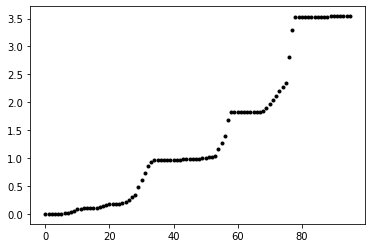

In [161]:
t = 0
i = 0
success = True
while t < bdf_obj.t_bound and success :
    out = bdf_obj._step_impl()
    success = out[0]
    t = bdf_obj.t
    plt.plot(i,t,'k.')
    i+= 1
im_arr = bdf_obj.y.copy()
im_arr.shape = simmer.dims[:-1]

In [165]:
from omnisim.solvers.bdf import *
t = bdf_obj.t
D = bdf_obj.D

max_step = bdf_obj.max_step
min_step = 10 * np.abs(np.nextafter(t, bdf_obj.direction * np.inf) - t)
if bdf_obj.h_abs > max_step:
    h_abs = max_step
    change_D(D, bdf_obj.order, max_step / bdf_obj.h_abs)
    bdf_obj.n_equal_steps = 0
elif bdf_obj.h_abs < min_step:
    h_abs = min_step
    change_D(D, bdf_obj.order, min_step / bdf_obj.h_abs)
    bdf_obj.n_equal_steps = 0
else:
    h_abs = bdf_obj.h_abs

atol = bdf_obj.atol
rtol = bdf_obj.rtol
order = bdf_obj.order

alpha = bdf_obj.alpha
gamma = bdf_obj.gamma
error_const = bdf_obj.error_const

J = bdf_obj.J
LU = bdf_obj.LU
current_jac = bdf_obj.jac is None

step_accepted = False
while not step_accepted:
    if h_abs < min_step:
        print('minstep failure')
        break
#         return False, bdf_obj.TOO_SMALL_STEP

    h = h_abs * bdf_obj.direction
    t_new = t + h

    if bdf_obj.direction * (t_new - bdf_obj.t_bound) > 0:
        t_new = bdf_obj.t_bound
        change_D(D, order, np.abs(t_new - t) / h_abs)
        bdf_obj.n_equal_steps = 0
        LU = None

    h = t_new - t
    h_abs = np.abs(h)

    y_predict = np.sum(D[:order + 1], axis=0)

    scale = atol + rtol * np.abs(y_predict)
    psi = np.dot(D[1: order + 1].T, gamma[1: order + 1]) / alpha[order]

    converged = False
    c = h / alpha[order]
    while not converged:
        if LU is None:
            LU = bdf_obj.lu(bdf_obj.I - c * J)

        converged, n_iter, y_new, d = solve_bdf_system(
            bdf_obj.fun, t_new, y_predict, c, psi, LU, bdf_obj.solve_lu,
            scale, bdf_obj.newton_tol)

        if not converged:
            if current_jac:
                break
            J = bdf_obj.jac(t_new, y_predict)
            LU = None
            current_jac = True

    if not converged:
        factor = 0.5
        h_abs *= factor
        change_D(D, order, factor)
        bdf_obj.n_equal_steps = 0
        LU = None
        continue

    safety = 0.9 * (2 * NEWTON_MAXITER + 1) / (2 * NEWTON_MAXITER
                                               + n_iter)

    scale = atol + rtol * np.abs(y_new)
    error = error_const[order] * d
    error_norm = norm(error / scale)

    if error_norm > 1:
        factor = max(MIN_FACTOR,
                     safety * error_norm ** (-1 / (order + 1)))
        h_abs *= factor
        change_D(D, order, factor)
        bdf_obj.n_equal_steps = 0
        # As we didn't have problems with convergence, we don't
        # reset LU here.
    else:
        step_accepted = True

bdf_obj.n_equal_steps += 1

bdf_obj.t = t_new
bdf_obj.y = y_new

bdf_obj.h_abs = h_abs
bdf_obj.J = J
bdf_obj.LU = LU

# Update differences. The principal relation here is
# D^{j + 1} y_n = D^{j} y_n - D^{j} y_{n - 1}. Keep in mind that D
# contained difference for previous interpolating polynomial and
# d = D^{k + 1} y_n. Thus this elegant code follows.
D[order + 2] = d - D[order + 1]
D[order + 1] = d
for i in reversed(range(order + 1)):
    D[i] += D[i + 1]

if bdf_obj.n_equal_steps < order + 1:
    raise Exception('finished')

if order > 1:
    error_m = error_const[order - 1] * D[order]
    error_m_norm = norm(error_m / scale)
else:
    error_m_norm = np.inf

if order < MAX_ORDER:
    error_p = error_const[order + 1] * D[order + 2]
    error_p_norm = norm(error_p / scale)
else:
    error_p_norm = np.inf

error_norms = np.array([error_m_norm, error_norm, error_p_norm])
with np.errstate(divide='ignore'): 
    factors = error_norms ** (-1 / np.arange(order, order + 3))

delta_order = np.argmax(factors) - 1
order += delta_order
bdf_obj.order = order

factor = min(MAX_FACTOR, safety * np.max(factors))
bdf_obj.h_abs *= factor
change_D(D, order, factor)
bdf_obj.n_equal_steps = 0
bdf_obj.LU = None

# return True, None

KeyboardInterrupt: 

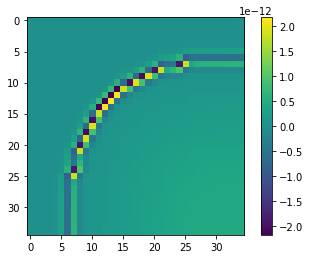

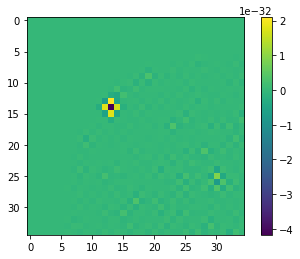

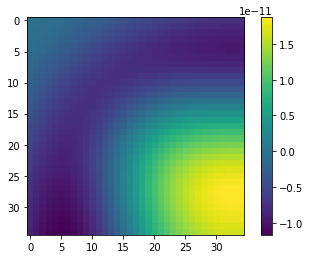

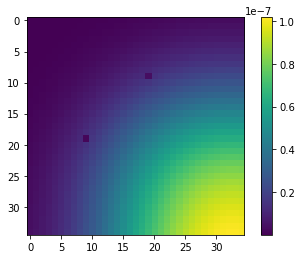

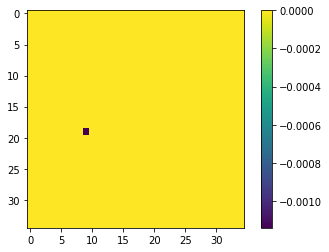

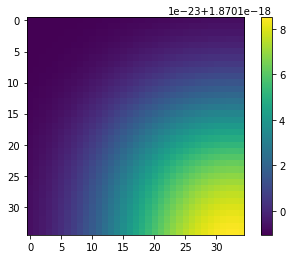

In [199]:
arr = D[2,:].reshape((ns,nh,nw))
for spec_i in np.arange(ns):
    plt.figure()
    plt.imshow(arr[spec_i,15:50,15:50])
    plt.colorbar()

In [166]:
problem_arr = (bdf_obj.I - c * J) 
ivec, jvec = problem_arr.nonzero()
vals = problem_arr[ivec, jvec]
badivec, badjvec = ivec[np.array(np.isnan(vals)).flatten()], jvec[np.array(np.isnan(vals)).flatten()]

In [167]:
ns, nh, nw, dx = simmer.dims
np.unique(badivec//(nw*nh))#,badjvec//(nw*nh))

array([], dtype=int32)

In [ ]:
oms.dhillda(y_predict.min(),2,50)

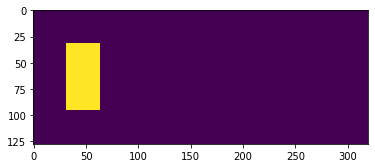

In [103]:

im_arr = bdf_obj.y.copy()
im_arr.shape = simmer.dims[:-1]
im_arr.shape = simmer.dims[:-1]
plt.imshow(im_arr[s_i,:,:])

In [168]:
for method in ['RK45', 'BDF', 'Radau', 'LSODA']:
    rtime = time.time()
    try:
        simmer.sim(p0,method=method)
    except:
        print(method + " failed")
        continue
    rtime = time.time() - rtime
    print(method)
    print(rtime)
    print(simmer.out)

/home/jmp/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


RK45
3570.8364045619965
  message: 'Required step size is less than spacing between numbers.'
     nfev: 198644
     njev: 0
      nlu: 0
      sol: None
   status: -1
  success: False
        t: array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206,
       208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232,
       234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258,
       260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284,
       286, 

In [70]:
im_arr[np.isnan(im_arr)] = 0
anim = write_movie(im_arr, t_vec)
HTML(anim.to_html5_video())

# Determine time scales of diffusion and reaction terms

In [80]:
import importlib
from omnisim import split_omnisim as oms
oms = importlib.reload(oms)

# Params :    ,Dc,    rc,  rp,   Kn,   Dn,  kn,  Da,  xa,    xs,  xS,
p0 = np.array([1e-3,    8e-3, 8e-3, 15,  3e-2,  0.1, 3e-2, 8e-2, 5e2, 2e2, 
#xr,   hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
1.2e3, 3.2, 100, 2.3, 55, 3.2, 2.7e3, 5e-3, 0, 1e-2], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rp,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
od0 = 1e-1
def sim_scale(sim_scale):
    simmer = oms.Simulator()
    simmer.set_scale(sim_scale)
    simmer.t_eval = np.arange(0,8*60,2)
    species, nh, nw, _ = simmer.dims
    cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(species)
    scale = simmer.scale
    # Setup initial conditions
    initial_array = np.zeros((species, nh, nw), dtype=np.float64, order='C')# + 1e-7
    initial_array[n_i,:,:] = 100
    initial_array[cs_i,scale:-scale,scale:2*scale] = od0
    initial_array[cs_i,:,:] = ndi.gaussian_filter(initial_array[cs_i,:,:], scale/4)
    initial_array[cp_i,scale:-scale,3*scale:-scale] = od0
    initial_array[cp_i,:,:] = ndi.gaussian_filter(initial_array[cp_i,:,:], scale/4)
    for ind in [cp_i, cs_i]:
        threshed = initial_array[ind,:,:] > min_od
        initial_array[ind,:,:] = initial_array[ind,:,:]*threshed

    simmer.initial_array = initial_array
    simmer.set_p0(p0)
    simmer.sim(p0, method='RK45')
    print('done {}'.format(sim_scale))
    return simmer
#     simmer.sim(p0, method='BDF')
#     im_arr = simmer.sim_arr
#     t_vec = simmer.sim_tvc
    # anim = write_movie(im_arr, t_vec)
    # print('random initial')

In [81]:
sim_list = [sim_scale(scale) for scale in [2,4,8,16]]

done 2
done 4
done 8
done 16


[None, None, None, None]

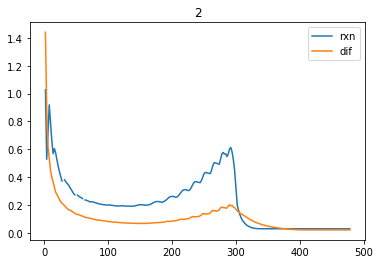

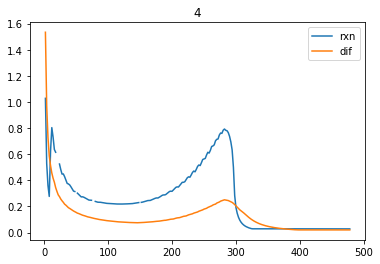

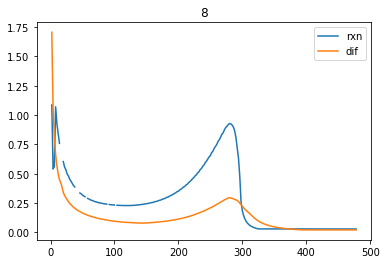

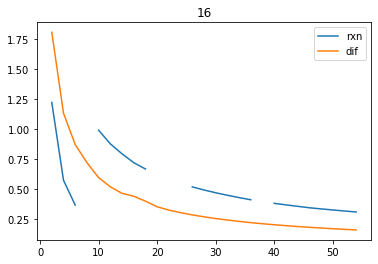

In [95]:
def plot_deriv_norms(simmer):
    scale = simmer.scale
    im_arr, t_vec = simmer.sim_arr, simmer.sim_tvc
    n_timepoints = len(t_vec)
    rxn_maxes = np.zeros(n_timepoints)
    dif_maxes = np.zeros(n_timepoints)
    rxn_deriv_arr = np.zeros_like(im_arr)
    dif_deriv_arr = np.zeros_like(im_arr)
    arr_shape = im_arr.shape[1:]
    for i in np.arange(n_timepoints):
        rxn_deriv_arr[i,:,:,:] = simmer.f_rxn_wrapper(0, im_arr[i,:,:,:].flatten()).reshape(arr_shape)
        rxn_maxes[i] = np.max(np.abs(rxn_deriv_arr[i,:,:,:]/(1e-3+im_arr[i,:,:,:])))
        dif_deriv_arr[i,:,:,:] = simmer.f_dif_wrapper(0, im_arr[i,:,:,:].flatten()).reshape(arr_shape)
        dif_maxes[i] = np.max(np.abs(dif_deriv_arr[i,:,:,:]/(1e-3+im_arr[i,:,:,:])))
    plt.figure()
    plt.plot(t_vec[1:], rxn_maxes[1:], label='rxn')
    plt.plot(t_vec[1:], dif_maxes[1:], label='dif')
    plt.legend()
    plt.title(scale)
#     print(scale)
    
[plot_deriv_norms(simmer) for simmer in sim_list]

For each reported simulation state, the ratio between system derivative and system state values was calculated. The maximum of such values were plotted above at each simulation time point. The plots show that the reaction terms are larger than the diffusion terms. I suppose this makes sense, as diffusion smooths differences between cell values, differences that necessarily are produced by the reaction terms. This probably indicates that, in a splitting scheme, the reaction step should decide the timestep for the diffusion solver. 

This does not answer the question of why the solvers tend the fail at higher resultion. My guess was that the diffusion terms were larger at higher scales, as the term 'dx' increases as the square of scale. This only appears to hold true for the very early time steps. 

Of course, the diffusion terms may be the deciding factor in the solver's convergence for higher scaling values, but that is not evident here. 

In [ ]:
deriv_arr = np.zeros_like(im_arr)
nt, ns, nh, nw = im_arr.shape
for i in np.arange(deriv_arr.shape[0]):
    deriv_vec = simmer.f_ivp_wrapper(0, im_arr[i,:,:,:].flatten())
    deriv_vec = deriv_vec.reshape((1,ns,nh,nw))
    deriv_arr[i,:,:,:] = deriv_vec
deriv_arr[np.isnan(deriv_arr)] = 0

In [ ]:
plt.imshow(im_arr[-1,a_i,:,:])
plt.title('rk sim ahl plot\nruntime:{}'.format(rk_rtime))

See if you can determine the order of the multigrid crank-nicolson method, and see whether multigrid actually speeds things up or not. Do this by testing out simple point-release diffusion. Naturally the initial condition should represent time $\epsilon > 0$. 

In [ ]:
def sim_err(scale=8, dt=1e-1, solver='v_cycle'):
    dif_simmer = oms.Simulator()
    dif_simmer.basedims = np.array([20,20])
    dif_simmer.set_scale(scale)
    dif_simmer.initial_array[[cs_i, n_i, cp_i],:,:] = 0
    ns, nh, nw, dx = dif_simmer.dims
    inds_arr = np.zeros((2, nh,nw))
    h_vec = np.arange(nh)
    w_vec = np.arange(nw)
    for i in h_vec:
        inds_arr[0,i,:] = w_vec
    for j in w_vec:
        inds_arr[1,:,j] = h_vec
    initial_n_input = np.power(inds_arr[0]-nw//2,2)
    initial_n_input += np.power(inds_arr[1]-nh//2,2)
    t = 10
    gauss_initial_n_input = np.exp(-initial_n_input/(dx*4*Dn*t))/(np.pi*4*dx*Dn*t)
    dif_simmer.initial_array[n_i,:,:] = gauss_initial_n_input
    dif_simmer.set_p0(p0)
    dif_impexp = cnmg_rk.CNMGRK(dif_simmer, 1e-3, 100)
    dif_impexp.cnmg_solver.dt = dt
    A = dif_impexp.cnmg_solver.cn_lhsA(0)
    y = dif_impexp.simmer.initial_array.flatten()
    b = dif_impexp.cnmg_solver.cn_rhsb(y.copy(), 0)
    if solver=='v_cycle':
        for i in range(300):
            dif_impexp.cnmg_solver.v_cycle(y, b, 0)
    if solver=='f_cycle':
        for i in range(300):
            dif_impexp.cnmg_solver.f_cycle(y, b, 0)
    if solver=='w_cycle':
        for i in range(300):
            dif_impexp.cnmg_solver.w_cycle(y, b, 0)
    if solver=='gmres':
        for i in range(300):
            y, info = splinalg.gmres(A, b, y)
    sim_y = y.reshape(ns, nh, nw)
    sim_t = 300*dif_impexp.cnmg_solver.dt
    true_arr = np.exp(-initial_n_input/(dx*4*Dn*sim_t))/(np.pi*4*dx*Dn*sim_t)
    err = np.sqrt((sim_y[n_i,:,:] - true_arr)**2)
    return np.sum(err)/(nh*nw)

In [ ]:

solver_list = ['v_cycle', 'f_cycle', 'w_cycle', 'gmres'][::-1]
scale_list = [4,8,16,32,64]
dt_list = np.power(2.0,-np.arange(1,11).astype(np.float))
n_rows = len(solver_list)*len(scale_list)*len(dt_list)
conv_table = pd.DataFrame(columns=['solver', 'scale', 'dt', 'err', 'runtime'], index=np.arange(n_rows))
i = 0
for solver in solver_list:
    for scale in scale_list:
        for dt in dt_list:
            c_start = time.time()
            err = sim_err(scale, dt, solver)
            c_run = time.time()-c_start
            conv_table.loc[i,:] = [solver, scale, dt, err, c_run]
            print([solver, scale, dt,err,c_run])
    conv_table.to_csv('test_dif_table_2.csv')


In [ ]:
y = im_arr[10,:,:,:]
# y.shape = (species, nh, nw)
dy = np.zeros_like(y)
diff_terms = np.zeros_like(y)
nut_avail = np.zeros_like(y[0,:,:])
oms.calc_f(y, dy, diff_terms, nut_avail, simmer.params)
# dy[s_i,:,:].max()
# plt.imshow(y[s_i,:,:])
plt.figure(figsize=(11,11))
jac_arr = simmer.jacobian.calc_jac_wrapper(0,y.flatten()).toarray()
plt.imshow(np.abs(jac_arr))

In [ ]:
y = initial_array
jac = simmer.jacobian.calc_jac_wrapper(0,y)
# i suppose use numpy's check_grad utility against the jacobian
bads = []
goods = []
species, nh, nw, _ = simmer.dims
for i in np.arange(species*nh*nw):
    f_lam = lambda y0 : simmer.f_ivp_wrapper(0,y0)[i]
    g_lam = lambda y0 : simmer.jacobian.calc_jac_wrapper(0,y0).toarray()[i,:]
#     err = opt.check_grad(f_lam, g_lam, y)
    err = opt.approx_fprime(y, f_lam,1e-8) - g_lam(y)
    bad_dus = np.arange(len(err))[err>1e-7]
    if np.all(np.isclose(0,err)):
        goods.append(i)
    else:
        for bad_du in bad_dus:
            u = bad_du // (nw*nh)
            bads.append((i//(nw*nh),u))

In [ ]:
i = 4
f_lam = lambda y0 : simmer.f_ivp_wrapper(0,y0)[i]
g_lam = lambda y0 : simmer.jacobian.calc_jac_wrapper(0,y0).toarray()[i,:]
err = opt.approx_fprime(y, f_lam,1e-7) - g_lam(y)

In [ ]:
from omnisim.solvers import impexp_cnmg_rk as cnmg_rk
cnmg_rk = importlib.reload(cnmg_rk)

In [ ]:
# simmer.set_p0(p0)
cnmg = cnmg_rk.cn_mg(simmer, 1e-2)
impexp = cnmg_rk.CNMGRK(simmer, 0, 2*60, first_step=5e-1)

In [ ]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()
for dt in [5,2,5e-1,5e-2]:
    impexp = cnmg_rk.CNMGRK(simmer, 0, 2*60, first_step=dt)
    ns, nh, nw, _ = simmer.dims
    n_loops = 1000
    rtime = time.time()
    for i in np.arange(n_loops):
        impexp._step_impl()
    rtime = time.time() - rtime
    err_arr = impexp.y
    err_arr = err_arr.reshape((ns,nh,nw))
    for i in np.arange(species):
        plt.figure()
        plt.imshow(err_arr[i,:,:])
        plt.title((dt, i, rtime))
#     b = cnmg.cn_rhsb_wrxn(x)
# #     cnmg.w_cycle(x,b,0)
#     out = splinalg.gmres(A, b, x)
# #     x = out[0]
#     if np.mod(i,n_loops/10)==0:
#         x = impexp.y.copy()
#         print(i)
#         print(impexp.cnmg_solver.dt)
#         x.shape = (ns,nh,nw)
#         axs[np.int(10*i/n_loops)].imshow(x[[cp_i,s_i],:,:].prod(axis=0))
#         x.shape = ns*nh*nw

In [ ]:
impexp.rk_solver.K.shape

In [ ]:
x = im_arr[5,:,:,:].flatten()
h=0
# x = cnmg.downscale(x, 0,h)
n = len(x0)
A = cnmg.cn_lhsA(h)#np.array([[4,-1,-6,0],[-5,-4,10,8],[0,9,4,-2],[1,0,-7,5]]).astype(np.float)
b = cnmg.cn_rhsb_wrxn(x)#np.array([[2,21,-12,-6]]).T.astype(np.float)
# b.shape = (len(b),1)
# x.shape = (len(x),1)
# x_true = linalg.solve(A,b)
# x = np.zeros_like(b)
class Callback():
    def __init__(self, A, b):
        self.i=0
        self.A = A
        self.b = b
    
    def plot_err(self, x0):
        plt.plot(self.i, np.log10(linalg.norm(self.A.dot(x0)-self.b.flatten())),'.k')
        self.i += 1
    
cb = Callback(A, b)
    
M = splinalg.LinearOperator(shape=(n,n), matvec=splinalg.spilu(A.tocsc()).solve)
out = splinalg.gmres(A, b, x,callback=cb.plot_err, callback_type='x')
if out[1] != 0:
    print('error')
x = out[0]

In [ ]:
A = cnmg.cn_lhsA(h)
b = cnmg.cn_rhsb_wrxn(x)
x = im_arr[1,:,:,:].flatten()
%time cnmg.w_cycle(x.copy(),b,0)
%time splinalg.gmres(A, b, x)#, maxiter=10)

In [ ]:
impexp.rk_solver.h_abs

In [ ]:
x = im_arr[50,:,:,:].flatten()
h=2
x = cnmg.downscale(x, 0,h)
A = cnmg.cn_lhsA(h)#np.array([[4,-1,-6,0],[-5,-4,10,8],[0,9,4,-2],[1,0,-7,5]]).astype(np.float)
b = cnmg.cn_rhsb(x,h)#np.array([[2,21,-12,-6]]).T.astype(np.float)
# x_true = linalg.solve(A,b)
# x = np.zeros_like(b)
for i in np.arange(40):
    print(i)
    cnmg_rk.gauss_seidel(A, b, x, n_iter=1, w=0.5)
    plt.plot(i, np.log10(linalg.norm(A.dot(x)-b)),'.k')

In [ ]:
Da

In [ ]:
x = im_arr[50,:,:,:].flatten()
h=0
# x = cnmg.downscale(x, 0,h)
A = cnmg.cn_lhsA(h)#np.array([[4,-1,-6,0],[-5,-4,10,8],[0,9,4,-2],[1,0,-7,5]]).astype(np.float)
b = cnmg.cn_rhsb(x,h)#np.array([[2,21,-12,-6]]).T.astype(np.float)
# x_true = linalg.solve(A,b)
# x = np.zeros_like(b)
# for i in np.arange(4):
#     print(i)
#     cnmg.v_cycle(x, b, h, n_iter=5)
#     plt.plot(i, np.log10(linalg.norm(A.dot(x)-b)),'.k')
%timeit splinalg.minres(A,b,x)

In [ ]:
x = im_arr[50,:,:,:].flatten()
h=0
# x = cnmg.downscale(x, 0,h)
A = cnmg.cn_lhsA(h)#np.array([[4,-1,-6,0],[-5,-4,10,8],[0,9,4,-2],[1,0,-7,5]]).astype(np.float)
b = cnmg.cn_rhsb(x,h)#np.array([[2,21,-12,-6]]).T.astype(np.float)
# x0 = x.copy()
# x_true = linalg.solve(A,b)
# x = np.zeros_like(b)
for i in np.arange(4):
    print(i)
    cnmg.f_cycle(x, b, h, n_iter=5)
#     x,_ = splinalg.gmres(A,b,x)
    plt.plot(i, np.log10(linalg.norm(A.dot(x)-b)),'.k')

In [ ]:
x = im_arr[50,:,:,:].flatten()
h=0
# x = cnmg.downscale(x, 0,h)
A = cnmg.cn_lhsA(h)#np.array([[4,-1,-6,0],[-5,-4,10,8],[0,9,4,-2],[1,0,-7,5]]).astype(np.float)
b = cnmg.cn_rhsb(x,h)#np.array([[2,21,-12,-6]]).T.astype(np.float)
# x_true = linalg.solve(A,b)
# x = np.zeros_like(b)
for i in np.arange(4):
    print(i)
    cnmg.w_cycle(x, b, h, n_iter=5)
    plt.plot(i, np.log10(linalg.norm(A.dot(x)-b)),'.k')

In [ ]:
x = im_arr[50,:,:,:].flatten()
h=0
# x = cnmg.downscale(x, 0,h)
A = cnmg.cn_lhsA(h)#np.array([[4,-1,-6,0],[-5,-4,10,8],[0,9,4,-2],[1,0,-7,5]]).astype(np.float)
b = cnmg.cn_rhsb(x,h)#np.array([[2,21,-12,-6]]).T.astype(np.float)
# x_true = linalg.solve(A,b)
# x = np.zeros_like(b)
# %lprun -f cnmg_rk.gauss_seidel cnmg_rk.gauss_seidel(A, b, x, n_iter=5)
# plt.plot(i, np.log10(linalg.norm(A.dot(x)-b)),'.k')

In [ ]:
def test1():
    i = 10
    Arow = A.getrow(i)
    _, inds = Arow.nonzero()
    # print(inds)
    sigma = 0
    for j in inds:
        if j != i:
            sigma += Arow[j]*x[j]
            
def test2():
    i = 10
    Arow = A.getrow(i).toarray()[0,:]
    Arow[i] = 0
    inds = Arow != 0
    # print(inds)
    sigma = 0
    for Aij, xj in zip(Arow[inds], x[inds]):
            sigma += Aij*xj

%timeit test1()
%timeit test2()

In [ ]:
def test1(x):
    w = 0.5
    n_iter = 5
    conv_eps = 1e-4
    n = len(x)
    #matnorm = norm
    matnorm = np.max
    diag = A.diagonal()
    # Perform relaxation
    residual = matnorm(A.dot(x)-b)
    while n_iter > 0 and residual > conv_eps:
        for i in np.arange(n):
            sigma = 0
            Arow = A.getrow(i)
            _, j_inds = Arow.nonzero()
            for j in j_inds:
                if j != i:
                    sigma = sigma + x[j]*Arow[0,j]
            x[i] = x[i] + w*((b[i]-sigma)/diag[i] -x[i])
        n_iter -= 1
        residual = matnorm(A.dot(x)-b)

def test2(x):
    w = 0.5
    n_iter = 5
    conv_eps = 1e-4
    n = len(x)
    #matnorm = norm
    matnorm = np.max
    diag = A.diagonal()
    # Perform relaxation
    residual = matnorm(A.dot(x)-b)
    ainz, ajnz = A.nonzero()
    nondiag = (ainz - ajnz) != 0
    i_nd, j_nd = ainz[nondiag], ajnz[nondiag]
    while n_iter > 0 and residual > conv_eps:
        sigma = 0
        for i in np.arange(n):
            sigma = 
            x[i_old] = x[i_old] + w*((b[i_old]-sigma)/diag[i_old] -x[i_old])
            sigma = 0
            i_old = i

        n_iter -= 1
        residual = matnorm(A.dot(x)-b)
        

# %timeit test1(x.copy())
# %timeit test2(x.copy())

In [ ]:
splinalg.norm(x1-x2)

In [ ]:
x = im_arr[50,:,:,:].flatten()
h=0
# x = cnmg.downscale(x, 0,h)
A = cnmg.cn_lhsA(h)#np.array([[4,-1,-6,0],[-5,-4,10,8],[0,9,4,-2],[1,0,-7,5]]).astype(np.float)
b = cnmg.cn_rhsb(x,h)#np.array([[2,21,-12,-6]]).T.astype(np.float)
# x_true = linalg.solve(A,b)
# x = np.zeros_like(b)
# for i in np.arange(40):
#     print(i)
#     test2(x)
#     plt.plot(i, linalg.norm(A.dot(x)-b),'.k')

In [ ]:
def test1(x):
    w = 0.5
    n_iter = 5
    conv_eps = 1e-4
    n = len(x)
    #matnorm = norm
    matnorm = np.max
    diag = A.diagonal()
    # Perform relaxation
    residual = matnorm(A.dot(x)-b)
    ainz, ajnz = A.nonzero()
    nondiag = (ainz - ajnz) != 0
    i_nd, j_nd = ainz[nondiag], ajnz[nondiag]
    i_nd_un = np.unique(i_nd)
    while n_iter > 0 and residual > conv_eps:
        for i in np.arange(n):
            if i in i_nd_un:
                mask = i_nd==i
                sub_j = j_nd[mask]
                sigma = np.sum([A[i,j]*x[j] for j in sub_j])
            else:
                sigma = 0
            x[i] = x[i] + w*((b[i]-sigma)/diag[i] -x[i])
        n_iter -= 1
        residual = matnorm(A.dot(x)-b)

def test2(x):
    w = 0.5
    n_iter = 5
    conv_eps = 1e-4
    n = len(x)
    #matnorm = norm
    matnorm = np.max
    diag = A.diagonal()
    # Perform relaxation
    residual = matnorm(A.dot(x)-b)
    ainz, ajnz = A.nonzero()
    nondiag = (ainz - ajnz) != 0
    i_nd, j_nd = ainz[nondiag], ajnz[nondiag]
    i_nd_un = np.unique(i_nd)
    while n_iter > 0 and residual > conv_eps:
        i_old = 0
        for i in i_nd_un:
            if i-i_old>1:
                x[i_old:i] = x[i_old:i] + w*(b[i_old:i]/diag[i_old:i] - x[i_old:i])
            mask = i_nd==i
            sub_j = j_nd[mask]
            sigma = np.sum([A[i,j]*x[j] for j in sub_j])
            x[i] = x[i] + w*((b[i]-sigma)/diag[i] - x[i])
            i_old = i
        i += 1
        if n-i>=1:
            x[i:] = x[i:] + w*(b[i:]/diag[i:] - x[i:])
        n_iter -= 1
        residual = matnorm(A.dot(x)-b)
        

%time test1(x.copy())
%time test2(x.copy())

In [ ]:
x1, x2 = x.copy(), x.copy()
test1(x1)
test2(x2)
linalg.norm(x1-x2)

In [ ]:
np.arange(len(x))[x1-x2==np.max(x1-x2)]//(nh*nw)

In [112]:
from scipy.sparse import linalg as splinalg

In [ ]:
ran_inds = lambda n_inds : np.random.choice(np.arange(len(x)), n_inds)
n = 100
%timeit A[ran_inds(n),ran_inds(n)]
%timeit [row.getcol(ran_inds(1)[0]) for row in [A.getrow(ran_inds(1)[0]) for yy in range(n)] for xx in range(n)]
%timeit [A[i,j] for i in ran_inds(n) for j in ran_inds(n)]

In [ ]:
N = 10000
M = 500
vol_weights = np.random.random(M)+0.5
vol_weights[0] = 1e3
sum_vol = vol_weights.sum()
avg_conc = n/sum_vol
